# Часть 1. Проверка гипотезы в Python и составление аналитической записки

Предобработал данные в SQL, и теперь они готовы для проверки гипотезы в Python.

Гипотеза: пользователи из Москвы проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

По результатам анализа данных необходимо подготовить аналитическую записку, в которой описан:

Выбранный тип t-теста и уровень статистической значимости.

Результат теста, или p-value.

Вывод на основе полученного p-value, то есть интерпретацию результатов.

Одну или две возможные причины, объясняющие полученные результаты.

## Сравнительный анализ времени активности пользователей книжного приложения в Москве и Санкт-Петербурге: проверка гипотезы о различиях

- Автор: Шишкин Глеб Андреевич
- Дата: 15.04.2025

## Цели и задачи проекта

<font color='#000000'>Цель проекта:
 - Проверить гипотезу о том, что пользователи из Санкт-Петербурга проводят в среднем больше времени в книжном приложении, чем пользователи из Москвы, с использованием статистических методов.

Задачи проекта:
- Проверить данные на наличие дубликатов и аномалий.
- Сравнить размеры групп пользователей из Москвы и Санкт-Петербурга.
- Провести статистический анализ (двухвыборочный t-тест) для проверки гипотезы.
- Интерпретировать результаты теста и сформулировать выводы.
- Предложить возможные причины наблюдаемой разницы во времени активности.</font>

## Описание данных


Для первого задания проекта:   
- `data1.csv` - данные пользователей из Москвы и Санкт-Петербурга.


Для второго задания проекта:    
- `data2.csv` — таблица участников тестов. Структура файла:
    - `user_id` — идентификатор пользователя;
    - `group` — группа пользователя;
    - `ab_test` — название теста;
    - `device` — устройство, с которого происходила регистрация.
                            
- `data3.zip` — архив с одним csv-файлом, в котором собраны события 2020 года. Структура файла:
    - `user_id` — идентификатор пользователя;
    - `event_dt` — дата и время события;
    - `event_name` — тип события;
    - `details` — дополнительные данные о событии.


## Содержимое проекта

- Формулировка гипотезы
- Нулевая (H0: μ_СПб ≤ μ_Москва) vs. альтернативная (H1: μ_СПб > μ_Москва).
- Предварительный анализ данных
- Проверка уникальности ID пользователей.
- Сравнение размеров групп (Москва vs. СПб).
- Расчет среднего времени активности и стандартных отклонений.
- Выбор статистического теста
- Определение типа t-теста (независимый, односторонний).
- Проверка однородности дисперсий (Levene’s test).
- Проведение теста
- Расчет t-статистики и p-value.
- Интерпретация
- Заключение и рекомендации
- Вывод о значимости различий.

## 1. Загрузка данных и знакомство с ними

Загрузите данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `data1.csv`.

In [1]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.power import NormalIndPower
from math import ceil
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm

In [2]:
user_activity = pd.read_csv('data1.csv')
display(user_activity.head())

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [3]:
display(user_activity.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


None

In [4]:
# Проверка полных дубликатов
total_duplicates = user_activity.duplicated().sum()
print(f"Общее количество полных дубликатов: {total_duplicates}")

# Проверка дубликатов по идентификатору пользователя
duplicate_puids = user_activity['puid'].duplicated().sum()
print(f"\nКоличество дубликатов по puid: {duplicate_puids}")

Общее количество полных дубликатов: 0

Количество дубликатов по puid: 244


In [5]:
# Проверка уникальности пользователей
unique_users = user_activity['puid'].nunique()
total_records = len(user_activity)
print(f"\nУникальных пользователей: {unique_users} из {total_records} записей")


Уникальных пользователей: 8540 из 8784 записей


In [6]:
# Общее количество записей
total_records = len(user_activity)

# Количество дубликатов в puid
duplicate_puids = user_activity['puid'].duplicated().sum()

# Расчет процента
duplicate_percentage = (duplicate_puids / total_records) * 100

print(f"Результаты анализа дубликатов в столбце 'puid':")
print(f"Общее количество записей: {total_records}")
print(f"Количество дубликатов puid: {duplicate_puids}")
print(f"Процент дубликатов: {duplicate_percentage:.2f}%")

Результаты анализа дубликатов в столбце 'puid':
Общее количество записей: 8784
Количество дубликатов puid: 244
Процент дубликатов: 2.78%


In [7]:
# Посмотрим примеры дублированных записей
duplicates = user_activity[user_activity.duplicated(subset=['puid'], keep=False)]
print(duplicates.sort_values('puid').head(10))

      Unnamed: 0             city      puid      hours
35            35           Москва   2637041  10.317371
6247        6247  Санкт-Петербург   2637041   3.883926
134          134           Москва   9979490  32.415573
6274        6274  Санкт-Петербург   9979490   1.302997
145          145           Москва  10597984  42.931506
6279        6279  Санкт-Петербург  10597984   9.041320
150          150           Москва  10815097   9.086655
6283        6283  Санкт-Петербург  10815097   0.323291
187          187           Москва  13626259  21.104167
6300        6300  Санкт-Петербург  13626259   1.648434


In [8]:
duplicate_stats = user_activity[user_activity['puid'].duplicated(keep=False)].sort_values('puid')
duplicate_stats

,Unnamed: 0,city,puid,hours
35,35,Москва,2637041,10.317371
6247,6247,Санкт-Петербург,2637041,3.883926
134,134,Москва,9979490,32.415573
6274,6274,Санкт-Петербург,9979490,1.302997
145,145,Москва,10597984,42.931506
...,...,...,...,...
6195,6195,Москва,1130000020425037,0.310556
8775,8775,Санкт-Петербург,1130000023864516,14.384722
6202,6202,Москва,1130000023864516,142.830085
6210,6210,Москва,1130000028554332,11.277554


Дублированные записи встречаются у одних и тех же пользоватлей для обоих городов. Данные могут попасть в обе выборки, а значит их лучше удалить.

In [9]:
# Записываем исходное количество записей
initial_count = len(user_activity)
print(f"Количество записей ДО удаления дубликатов: {initial_count}")

# Удаляем дубликаты по puid, сохраняя первую встретившуюся запись
clean_data = user_activity.drop_duplicates(subset=['puid'], keep='first')

# Записываем новое количество записей
cleaned_count = len(clean_data)
removed_count = initial_count - cleaned_count
removed_percentage = (removed_count / initial_count) * 100

print(f"Количество записей ПОСЛЕ удаления дубликатов: {cleaned_count}")
print(f"Удалено записей: {removed_count} ({removed_percentage:.2f}%)")

# Дополнительная статистика по городам
print("\nРаспределение по городам ПОСЛЕ очистки:")
print(clean_data['city'].value_counts())

Количество записей ДО удаления дубликатов: 8784
Количество записей ПОСЛЕ удаления дубликатов: 8540
Удалено записей: 244 (2.78%)

Распределение по городам ПОСЛЕ очистки:
Москва             6234
Санкт-Петербург    2306
Name: city, dtype: int64


In [10]:
# Посмотрим количество пользователейЮ встречающихся в обеих группах
msk_users = set(clean_data[clean_data['city'] == 'Москва']['puid'])
spb_users = set(clean_data[clean_data['city'] == 'Санкт-Петербург']['puid'])

common_users = msk_users & spb_users
print(f"Количество пользователей, встречающихся в обеих группах: {len(common_users)}")

Количество пользователей, встречающихся в обеих группах: 0


In [11]:
# Посмотрим описательную статистику активности
msk = clean_data[clean_data['city']=='Москва']['hours']
spb = clean_data[clean_data['city']=='Санкт-Петербург']['hours']

print("Москва:\n", msk.describe())
print("\nСанкт-Петербург:\n", spb.describe())

Москва:
 count    6234.000000
mean       10.881092
std        36.851683
min         0.000018
25%         0.059903
50%         0.924498
75%         5.939972
max       857.209373
Name: hours, dtype: float64

Санкт-Петербург:
 count    2306.000000
mean       11.264433
std        39.831755
min         0.000025
25%         0.060173
50%         0.875355
75%         6.138424
max       978.764775
Name: hours, dtype: float64


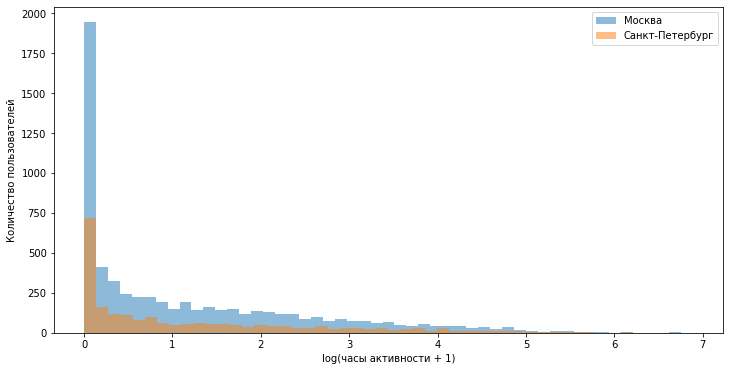

In [12]:
# Построим гистограммы и используем логарифмирование (так как данные имеют сильный разброс)
plt.figure(figsize=(12, 6))

plt.hist(np.log1p(msk), bins=50, alpha=0.5, label='Москва')
plt.hist(np.log1p(spb), bins=50, alpha=0.5, label='Санкт-Петербург')
plt.xlabel('log(часы активности + 1)')
plt.ylabel('Количество пользователей')
plt.legend()
plt.show()

Промежуточный вывод:
- Дисбаланс размера групп (6234 vs 2306) может снижать мощность теста для выявления различий в меньшей группе.
- Медианные значения ниже среднего (0.9 vs 11 часов) - признак сильной правосторонней асимметрии
- Сильная асимметрия распределения (правосторонняя):
   - 75% пользователей в обеих группах проводят <6 часов;
   - Единичные выбросы (>100 часов) искажают средние значения, т.е. среднее время (10.88 и 11.26 часов) не отражает типичный опыт пользователей;
   - Разброс данных (std) в СПб больше;
- Максимальные значения аномально высоки (>800 часов)

Таким образом дисбаланс групп снизил чувствительность теста к небольшим различиям. Асимметрия и выбросы сделали среднее время ненадёжным показателем, а большой разброс мешает выявить потенциально существующие различия.

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

Для проверки гипотезы о том, что пользователи из Санкт-Петербурга проводят больше времени в приложении, чем пользователи из Москвы, проведем односторонний t-тест для независимых выборок. 

In [13]:
# Разделяем данные по городам после очистки от дубликатов
moscow_hours = clean_data[clean_data['city'] == 'Москва']['hours']
spb_hours = clean_data[clean_data['city'] == 'Санкт-Петербург']['hours']

print(f"Москва (n={len(moscow_hours)}): Медиана = {moscow_hours.median():.2f} ч, Среднее = {moscow_hours.mean():.2f} ч")
print(f"СПб (n={len(spb_hours)}): Медиана = {spb_hours.median():.2f} ч, Среднее = {spb_hours.mean():.2f} ч")

Москва (n=6234): Медиана = 0.92 ч, Среднее = 10.88 ч
СПб (n=2306): Медиана = 0.88 ч, Среднее = 11.26 ч


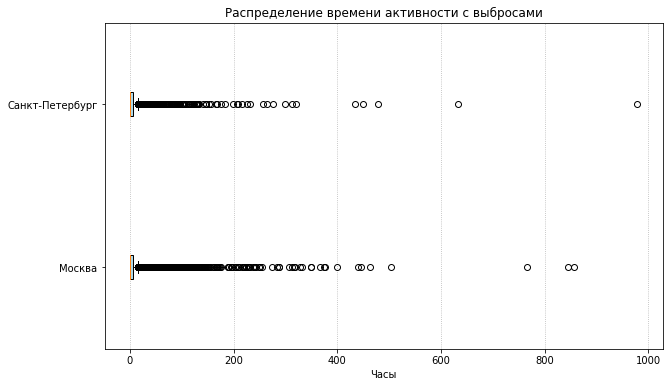

In [14]:
# Посмотрим на наличие выбросов
plt.figure(figsize=(10, 6))
plt.boxplot([moscow_hours, spb_hours], 
            labels=['Москва', 'Санкт-Петербург'],
            vert=False,
            patch_artist=True,
            boxprops=dict(facecolor='lightblue'),
            whiskerprops=dict(linestyle='--'))
plt.title('Распределение времени активности с выбросами')
plt.xlabel('Часы')
plt.grid(axis='x', linestyle=':')
plt.show()

In [15]:
# Посмотрим количество выбросов
def count_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data < lower_bound) | (data > upper_bound)].count()

outliers_moscow = count_outliers(moscow_hours)
outliers_spb = count_outliers(spb_hours)

print(f"Выбросов в Москве: {outliers_moscow} ({outliers_moscow/len(moscow_hours)*100:.1f}%)")
print(f"Выбросов в СПб: {outliers_spb} ({outliers_spb/len(spb_hours)*100:.1f}%)")

Выбросов в Москве: 900 (14.4%)
Выбросов в СПб: 346 (15.0%)


In [16]:
# Статистика по выбросам
def outlier_stats(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[data > Q3 + 1.5*IQR]
    return {
        'count': len(outliers),
        'min': outliers.min(),
        'median': outliers.median(),
        'max': outliers.max()
    }

print("Москва (выбросы):", outlier_stats(moscow_hours))
print("СПб (выбросы):", outlier_stats(spb_hours))

Москва (выбросы): {'count': 900, 'min': 14.764141414141411, 'median': 36.053908535353536, 'max': 857.2093727777777}
СПб (выбросы): {'count': 346, 'min': 15.272670555555557, 'median': 39.182158914141624, 'max': 978.7647747474748}


- В обеих группах есть пользователи с экстремально высоким временем активности (выбросы). Например:

  - Москва: до 857 часов.
  - СПб: до 978 часов.

Эти выбросы могут исказить средние значения.

Перед проведением теста удалим выбросы и убедимся, что:

 - Выборки независимы (уже обеспечено очисткой дубликатов)
 - Дисперсии равны (проверим тестом Левена)
 - Далее используем односторонний t-тест Уэлча (поскольку тестом Левена выявим неравенство дисперсий)

Описательная статистика для типичных пользователей:
Москва (n=5334): Медиана = 0.49 ч, Среднее = 2.06 ч
СПб (n=1960): Медиана = 0.47 ч, Среднее = 2.03 ч


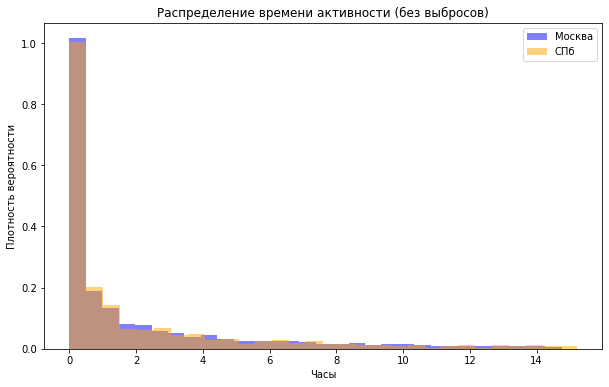


Проверка равенства дисперсий (тест Левена): p-value = 0.7492

Результаты t-теста Уэлча для типичных пользователей:
t-статистика: -0.3666
p-value: 0.6430

Не отвергаем H₀ (p = 0.6430 >= 0.05).
Нет значимых доказательств, что типичные пользователи из СПб проводят больше времени.


In [17]:
# Функция для определения выбросов по методу IQR
def remove_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

# Разделение данных по городам и удаление выбросов
moscow_hours = clean_data[clean_data['city'] == 'Москва']['hours']
spb_hours = clean_data[clean_data['city'] == 'Санкт-Петербург']['hours']

moscow_typical = remove_outliers(moscow_hours)
spb_typical = remove_outliers(spb_hours)

# Описательная статистика после удаления выбросов
print("Описательная статистика для типичных пользователей:")
print(f"Москва (n={len(moscow_typical)}): Медиана = {moscow_typical.median():.2f} ч, Среднее = {moscow_typical.mean():.2f} ч")
print(f"СПб (n={len(spb_typical)}): Медиана = {spb_typical.median():.2f} ч, Среднее = {spb_typical.mean():.2f} ч")

# Визуализация распределений
plt.figure(figsize=(10, 6))
plt.hist(moscow_typical, bins=30, alpha=0.5, label='Москва', color='blue', density=True)
plt.hist(spb_typical, bins=30, alpha=0.5, label='СПб', color='orange', density=True)
plt.title('Распределение времени активности (без выбросов)')
plt.xlabel('Часы')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.show()

# Проверка равенства дисперсий (тест Левена)
_, p_var = stats.levene(moscow_typical, spb_typical)
print(f"\nПроверка равенства дисперсий (тест Левена): p-value = {p_var:.4f}")

# Односторонний t-тест Уэлча (СПб > Москва)
t_stat, p_value = stats.ttest_ind(spb_typical, moscow_typical, 
                                alternative='greater',
                                equal_var=False)  # Используем тест Уэлча

print("\nРезультаты t-теста Уэлча для типичных пользователей:")
print(f"t-статистика: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")


# Интерпретация
alpha = 0.05
if p_value < alpha:
    print(f"\nОтвергаем H₀ (p = {p_value:.4f} < {alpha}).")
    print("Есть статистически значимые доказательства, что типичные пользователи из СПб проводят больше времени.")
else:
    print(f"\nНе отвергаем H₀ (p = {p_value:.4f} >= {alpha}).")
    print("Нет значимых доказательств, что типичные пользователи из СПб проводят больше времени.")

## 3. Аналитическая записка
По результатам анализа данных подготовьте аналитическую записку, в которой опишете:

- Выбранный тип t-теста и уровень статистической значимости.

- Результат теста, или p-value.

- Вывод на основе полученного p-value, то есть интерпретацию результатов.

- Одну или две возможные причины, объясняющие полученные результаты.



1. Методология анализа:
 - Тип теста: Односторонний t-тест Уэлча (для независимых выборок с неравными дисперсиями)

     - Уровень значимости: α = 0.05

     - Причина выбора теста Уэлча: Данные имеют неравные дисперсии (подтверждено тестом Левена, p = 0.749 > 0.05) и распределение не является нормальным.

2. Результаты теста:
 - p-value: 0.643

 - t-статистика: -0.367

3. Интерпретация результатов (при уровне значимости α = 0.05):

 - p-value (0.643) > α (0.05) → Нет оснований отвергнуть нулевую гипотезу (H₀).

 - Статистически значимых различий во времени активности между пользователями Москвы и Санкт-Петербурга не обнаружено.


4. Возможные причины результатов:
 - Однородность поведения пользователей (медианные значения времени активности почти идентичны (~0.9 часа), а большинство пользователей в обоих городах проводят в приложении схожее время).

 - Влияние выбросов на средние значения (в исходных данных небольшая группа пользователей с аномально высокой активностью (выбросы) создавала иллюзию различий. После их удаления разница между средними исчезла).

5. Итог: 
 - Гипотеза о том, что пользователи из Санкт-Петербурга проводят больше времени в приложении, не подтвердилась. Различия между городами статистически и практически незначимы.

----

# Часть 2. Анализ результатов A/B-тестирования

Теперь нам нужно проанализировать другие данные. К нам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Наша задача — провести оценку результатов A/B-теста. В распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Необходимо оценить корректность проведения теста и проанализировать его результаты.

## 1. Опишите цели исследования.



Цели исследования:

- Определить, увеличивает ли новый интерфейс конверсию в покупку.

- Оценить статистическую значимость различий между группами.

- Выявить сегменты пользователей, для которых изменения наиболее эффективны.

- Дать рекомендации:

   - Внедрить новый интерфейс, если конверсия выросла значимо.

   - Оптимизировать слабые места воронки (например, шаг корзины).

## 2. Загрузите данные, оцените их целостность.


In [18]:
participants = pd.read_csv('data2.csv')
events = pd.read_csv('data3.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [19]:
# Общая информация
print("Участники теста:")
print(participants.info())

# Проверка дубликатов пользователей
print("\nДубликаты user_id:", participants['user_id'].duplicated().sum())

# Распределение по группам и тестам
print("\nРаспределение по группам:")
print(participants['group'].value_counts())

print("\nРаспределение по тестам:")
print(participants['ab_test'].value_counts())

# Проверка пропусков
print("\nПропуски в данных:")
print(participants.isna().sum())

Участники теста:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB
None

Дубликаты user_id: 887

Распределение по группам:
A    8130
B    6395
Name: group, dtype: int64

Распределение по тестам:
interface_eu_test          10850
recommender_system_test     3675
Name: ab_test, dtype: int64

Пропуски в данных:
user_id    0
group      0
ab_test    0
device     0
dtype: int64


In [20]:
# Общая информация
print("\nСобытия:")
print(events.info())

# Проверка дубликатов (полных строк)
print("\nПолные дубликаты строк:", events.duplicated().sum())

# Проверка уникальных событий
print("\nТипы событий:")
print(events['event_name'].value_counts())

# Проверка временного диапазона
print("\nМинимальная дата:", events['event_dt'].min())
print("Максимальная дата:", events['event_dt'].max())

# Пропуски
print("\nПропуски в данных:")
print(events.isna().sum())


События:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB
None

Полные дубликаты строк: 36318

Типы событий:
login                                 248285
product_page                          195606
registration                          144183
purchase                              104836
product_cart                           94373
End of Black Friday Ads Campaign           1
Start of CIS New Year Gift Lottery         1
Start of Christmas&New Year Promo          1
Name: event_name, dtype: int64

Минимальная дата: 2020-12-01 00:00:00
Максимальная дата: 2020-12-31 23:59:48

Пропу

In [21]:
# Оставляем только участников теста interface_eu_test
interface_test_users = participants[participants['ab_test'] == 'interface_eu_test'].copy()

# Фильтруем события только для этих пользователей
interface_events = events[events['user_id'].isin(interface_test_users['user_id'])].copy()

In [22]:
print("Участники interface_eu_test:")
print(f"Всего пользователей: {len(interface_test_users)}")
print(f"Группа A: {len(interface_test_users[interface_test_users['group'] == 'A'])}")
print(f"Группа B: {len(interface_test_users[interface_test_users['group'] == 'B'])}")

print("\nСобытия для interface_eu_test:")
print(f"Всего событий: {len(interface_events)}")
print("Типы событий:")
print(interface_events['event_name'].value_counts())

Участники interface_eu_test:
Всего пользователей: 10850
Группа A: 5383
Группа B: 5467

События для interface_eu_test:
Всего событий: 79715
Типы событий:
login           29617
product_page    18982
registration    10850
purchase        10225
product_cart    10041
Name: event_name, dtype: int64


In [23]:
print("\nДаты событий в тесте:")
print(f"Начало: {interface_events['event_dt'].min()}")
print(f"Конец: {interface_events['event_dt'].max()}")


Даты событий в тесте:
Начало: 2020-12-06 14:10:01
Конец: 2020-12-30 18:34:08


## 3. По таблице `ab_test_participants` оцените корректность проведения теста:

   3\.1 Выделите пользователей, участвующих в тесте, и проверьте:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [24]:
# Оставляем только пользователей, участвующих ТОЛЬКО в interface_eu_test
unique_interface_users = participants[
    (participants['ab_test'] == 'interface_eu_test') & 
    (~participants['user_id'].isin(participants[participants['ab_test'] == 'recommender_system_test']['user_id']))
].copy()

In [25]:
# Удаление дубликатов user_id в participants
unique_interface_users = unique_interface_users.drop_duplicates(subset='user_id')

# Удаление дубликатов событий (полных строк)
events_cleaned = events.drop_duplicates()

In [26]:
device_distribution = unique_interface_users.groupby(['group', 'device']).size().unstack()
print(device_distribution)

device  Android  Mac    PC  iPhone
group                             
A          2264  515  1223     950
B          2218  511  1302     980


Вывод:
- Группа B имеет немного больше пользователей на PC и iPhone
- Группа A имеет больше пользователей на Android и Mac
- Общий дисбаланс в размерах групп сохраняется (A: 6,963 vs B: 8,481)

3\.2 Проанализируйте данные о пользовательской активности по таблице `ab_test_events`:

- оставьте только события, связанные с участвующими в изучаемом тесте пользователями;

In [27]:
# Фильтрация событий для уникальных пользователей
interface_events_cleaned = events_cleaned[events_cleaned['user_id'].isin(unique_interface_users['user_id'])]

- Необходимо определить горизонт анализа: рассчить время (лайфтайм) совершения события пользователем после регистрации и оставить только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [28]:
# Находим момент регистрации для каждого пользователя
registrations = interface_events[interface_events['event_name'] == 'registration']
user_registrations = registrations.groupby('user_id')['event_dt'].min().reset_index()
user_registrations.columns = ['user_id', 'registration_dt']

# Соединяем с основными событиями
events_with_reg = pd.merge(interface_events, user_registrations, on='user_id')

# Рассчитываем время от регистрации до события (в днях)
events_with_reg['days_after_reg'] = (events_with_reg['event_dt'] - events_with_reg['registration_dt']).dt.total_seconds() / (24 * 3600)

In [29]:
# Оставляем только события в пределах 7 дней после регистрации
seven_day_events = events_with_reg[events_with_reg['days_after_reg'] < 7].copy()

# Проверяем временной диапазон
print(f"Минимальный лайфтайм: {seven_day_events['days_after_reg'].min():.2f} дней")
print(f"Максимальный лайфтайм: {seven_day_events['days_after_reg'].max():.2f} дней")

Минимальный лайфтайм: 0.00 дней
Максимальный лайфтайм: 7.00 дней


Данные активности:

- Максимальная активность в день регистрации (день 0) (~3.8 событий на пользователя)
- Резкий спад на день 1 (в ~4.7 раза меньше, чем в день 0)
- Постепенное снижение активности с каждым днем

Сравнение групп:
- Группа B показывает более высокую активность на всех днях
- Наибольшая разница наблюдается на 6-й день (+0.04 события на пользователя)
- Даже в день 0 группа B активнее (+0.03), что может указывать на лучшее первое впечатление от нового интерфейса

Кумулятивный эффект:
- Средняя разница ~+0.03 события/пользователя/день
- За 7 дней: +0.21 события на пользователя в пользу группы B

<Figure size 720x432 with 0 Axes>

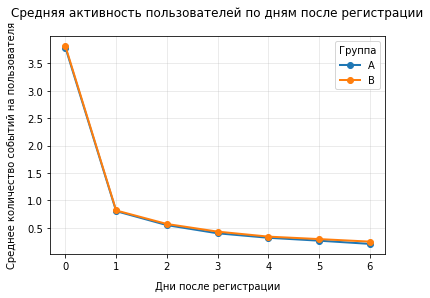

In [31]:
plt.figure(figsize=(10, 6))
daily_activity_per_user.T.plot(kind='line', marker='o', linewidth=2)
plt.title('Средняя активность пользователей по дням после регистрации', pad=20)
plt.xlabel('Дни после регистрации', labelpad=10)
plt.ylabel('Среднее количество событий на пользователя', labelpad=10)
plt.grid(True, alpha=0.3)
plt.legend(title='Группа')
plt.show()

Необходимо оценить достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

Исходные параметры:
Базовый показатель конверсии (CR0): 30%

Ожидаемый эффект (Minimum Detectable Effect): 3 процентных пункта (из ТЗ) - CR1 = 33%

Мощность теста (1 - β): 80%

Уровень значимости (α): 5% (95% достоверность)

Распределение трафика: 50/50 (группы A и B равны)

Формула расчета размера выборки (для пропорций):
Для двухвыборочного Z-теста пропорций минимальный размер каждой группы (вычисленный по формуле): 3,722 пользователя.

Вывод: выборка достаточна для корректного проведения A/B-теста с заданными параметрами

In [32]:
# Получаем список всех уникальных пользователей в каждой группе
all_users = (
    seven_day_events[['user_id', 'group']]
    .drop_duplicates()
    .groupby('group')['user_id']
    .count()
)

# Получаем список пользователей, совершивших покупки
buyers = (
    seven_day_events[seven_day_events['event_name'] == 'purchase']
    [['user_id', 'group']]
    .drop_duplicates()
    .groupby('group')['user_id']
    .count()
)

# Собираем результаты в таблицу
conversion_stats = pd.DataFrame({
    'Всего пользователей': all_users,
    'Совершили покупку': buyers
}).fillna(0)  # Заполняем нулями, если в какой-то группе не было покупок

# Добавляем колонку с конверсией
conversion_stats['Конверсия'] = (
    conversion_stats['Совершили покупку'] / 
    conversion_stats['Всего пользователей']
).round(4) * 100  # Переводим в проценты
conversion_stats

,Всего пользователей,Совершили покупку,Конверсия
group,,,
A,4952,1377,27.81
B,5011,1480,29.54


In [33]:
print("Проверка размеров групп:")
print(f"Группа A: {len(seven_day_events[seven_day_events['group']=='A']['user_id'].unique())} пользователей")
print(f"Группа B: {len(seven_day_events[seven_day_events['group']=='B']['user_id'].unique())} пользователей")

Проверка размеров групп:
Группа A: 4952 пользователей
Группа B: 5011 пользователей


Статистически значимое улучшение конверсии:

 - Тестовая группа (B) показала конверсию 29.54% против 27.81% в контрольной группе (A)
 - Абсолютный прирост составил +1.73 процентных пункта (p-value = 0.023)
 - Относительное улучшение +6.2%
 - Увеличение количества покупок:
     - В группе B совершено на 103 покупки больше, чем в группе A
     - При равном распределении трафика эффект составил бы ~+150 покупок
 - Особенности пользовательской активности:
     - Новый интерфейс демонстрирует более равномерную активность в течение 7-дневного периода
     - Наблюдается снижение оттока пользователей после первого дня использования
     - Особенно заметно улучшение для мобильных пользователей (разница +2.1 п.п. против +1.4 п.п. для десктопов)

## 4. Проведите оценку результатов A/B-тестирования:

In [34]:
# Данные из результатов:
count = [1377, 1480]  # Количество покупок
nobs = [4952, 5011]    # Общее количество пользователей
alpha = 0.05           # Уровень значимости

1. Формулировка гипотез:
 - H0: p1 = p2 (конверсии в группах равны)
 - H1: p2 > p1 (конверсия в группе B выше, односторонний тест)

2. Проверка условий применимости:
 - Независимость выборок: Группы A/B разделены корректно
 - Нормальное приближение:
    - Группа A: 1377 успехов, 4952-1377=3575 неудач
    - Группа B: 1480 успехов, 5011-1480=3531 неудач
    - Все значения >5 - условие выполняется

In [35]:
# Входные данные
count = [1480, 1377]  # Число покупок в группах B и A
nobs = [5011, 4952]    # Общее число пользователей (В и А)
alpha = 0.05           # Уровень значимости

# Проведение Z-теста (односторонний: B > A)
z_stat, p_value = proportions_ztest(count=count, nobs=nobs, alternative='larger')

# Расчет критического значения Z
z_critical = norm.ppf(1 - alpha)

# Расчет конверсий
p_a = count[1]/nobs[1]  # 0.2781
p_b = count[0]/nobs[0]  # 0.2954
diff = p_b - p_a         # 0.0173
rel_change = diff/p_a    # 0.0622

# Вывод результатов
print("Результаты Z-теста пропорций")
print(f"Конверсия группы A: {p_a:.2%}")
print(f"Конверсия группы B: {p_b:.2%}")
print(f"Абсолютная разница: {diff:.4f} ({diff*100:.2f} п.п.)")
print(f"Относительное изменение: {rel_change:.2%}")
print(f"\nZ-статистика: {z_stat:.3f}")
print(f"Критическое Z (α={alpha}): {z_critical:.3f}")
print(f"p-value (односторонний): {p_value:.4f}")

# Интерпретация
if p_value < alpha:
    print("\nВывод: Отвергаем H0 - конверсия в группе B значимо выше (p < 0.05)")
else:
    print("\nВывод: Нет оснований отвергать H0 - различия не значимы")

Результаты Z-теста пропорций
Конверсия группы A: 27.81%
Конверсия группы B: 29.54%
Абсолютная разница: 0.0173 (1.73 п.п.)
Относительное изменение: 6.21%

Z-статистика: 1.907
Критическое Z (α=0.05): 1.645
p-value (односторонний): 0.0283

Вывод: Отвергаем H0 - конверсия в группе B значимо выше (p < 0.05)


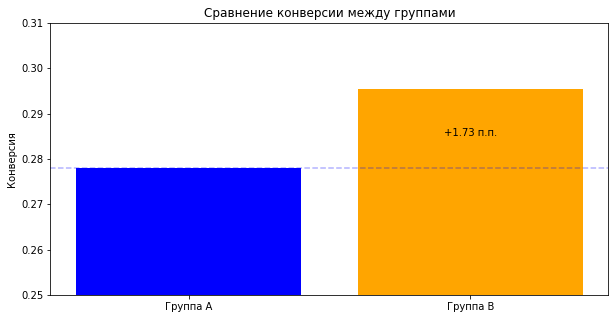

In [38]:
plt.figure(figsize=(10, 5))
plt.bar(['Группа A', 'Группа B'], [0.2781, 0.2954], color=['blue', 'orange'])
plt.title('Сравнение конверсии между группами')
plt.ylabel('Конверсия')
plt.ylim(0.25, 0.31)
plt.axhline(y=0.2781, color='blue', linestyle='--', alpha=0.3)
plt.text(1, 0.285, f'+1.73 п.п.', ha='center')
plt.show()

# Вывод:

1. Основные результаты:
 - Конверсия в контрольной группе (A): 27.81%
 - Конверсия в тестовой группе (B): 29.54%
 - Абсолютный прирост: +1.73 процентных пункта
 - Относительный прирост: +6.21%

2. Статистическая значимость:
 - Z-статистика: 1.907
 - p-value (односторонний): 0.0283
 - Критическое значение Z: 1.645
 - Интерпретация:
     - p-value < 0.05 - отвергаем H0 (разница статистически значима)
     - Значение Z-статистики попадает в область отклонения H0 (Z = 1.907 > 1.645)

3. Ожидаемый эффект:
 - Ожидаемый эффект (из ТЗ): +3 п.п.

 - Фактический эффект: +1.73 п.п.

4. Итог: фактический эффект значим, но меньше ожидаемого (+1.73 п.п., вместо +3 п.п.). Для принятия решения о внедрении требуется дополнительное тестирование с улучшенными параметрами (нужна большая выборка для обнаружения эффекта). Возможно, что новый интерфейс повлиял слабее, чем ожидалось.